In [1]:
import os
import h5py
import gvar   as gv
import numpy  as np
import pandas as pd
from   matplotlib import pyplot as plt

def RatioFileString(name,ts,h,hss,q,l,p):
    return f'{name}T{ts}{h}_RW_{hss}_rot_rot{q}{l}_p{p}'

def format(v):
    return gv.gvar(
        v.mean(axis=0),
        v.std(axis=0) * np.sqrt(v.shape[0]-1)
    )

def plot(v,**kwargs):
    plt.errorbar(
        np.arange(len(v)),
        gv.mean(v),
        gv.sdev(v),
        fmt='.',
        **kwargs
    )

def jkCorr(data, bsize=1):
    if bsize==0:
        return data
    else:
        rData = (data.shape[0]//bsize)
        nData = rData*bsize
        dIn   = data[0:nData,:]

        avg   = dIn.mean(axis=0)

        base  = dIn.sum(axis=0) # avg * nData

        dOut  = dIn * 0.0

        for cf in range(rData):
            pvg = dIn[cf*bsize:(cf+1)*bsize,:].sum(axis=0)
            dOut[cf,:] = (base - pvg)/(nData - bsize)

        return dOut[:rData,:]

In the following cell import `FnalHISQMetadata` module giving the correct path

In [2]:
from b2heavy.FnalHISQMetadata import params # change

ens = 'Coarse-1'
mom = '000'
jk  = 11

mdata = params(ens)
Ta,Tb = mdata['hSinks']

heavy = '_k' + mdata['kBStr']
light = '_k' + mdata['kDStr']
qq    = '_m' + mdata['mlStr']

data = h5py.File(f'/Users/pietro/code/data_analysis/BtoD/Alex/Ensembles/FnalHISQ/a0.12/{mdata["hdf5File2"]}')
data = data['data']

$$
 R_{A_1}(\mathbf{p}_\perp,t,T) = \frac{ C_{B_{1S}\rightarrow D^*_a}^{A_j}(\mathbf{p}_\perp,t,T) \,\, C_{D^*_a\rightarrow B_{1S}}^{A_j}(\mathbf{p}_\perp,t,T) }{  C_{D^*_a\rightarrow D^*_{1S}}^{V_4}(\mathbf{0},t,T) \,\,   C_{B_{1S}\rightarrow B_{1S}}^{V_4}(\mathbf{0},t,T) } / \Biggl[\frac{Z_{D^*_a}(\mathbf p_\perp)}{\sqrt{Z_{D^*_a}(0)Z_{D_{1S}^*}(0)}} \frac{{M_{D^*}}^2}{{E^2_{D^*}}(\mathbb p)} e^{-({E_{D^*}}(\mathbb p) - M_{D^*})T}\Biggr]
$$ 

## Reading

in the following cells we read the data from the archive and we build the uncorrected ratio for each smearing and each sink time and we put it in a dictionary `data_read`

------------- tsink = 12 --------- smr = '1S' -------------------
P5_A1_V1_T12_k0.08574_RW_1S_rot_rot_m0.00507_k0.12201_p000
V1_A1_P5_T12_k0.12201_RW_1S_rot_rot_m0.00507_k0.08574_p000
V1_V4_V1_T12_k0.12201_RW_1S_rot_rot_m0.00507_k0.12201_p000
P5_V4_P5_T12_k0.08574_RW_1S_rot_rot_m0.00507_k0.08574_p000
------------- tsink = 13 --------- smr = '1S' -------------------
P5_A1_V1_T13_k0.08574_RW_1S_rot_rot_m0.00507_k0.12201_p000
V1_A1_P5_T13_k0.12201_RW_1S_rot_rot_m0.00507_k0.08574_p000
V1_V4_V1_T13_k0.12201_RW_1S_rot_rot_m0.00507_k0.12201_p000
P5_V4_P5_T13_k0.08574_RW_1S_rot_rot_m0.00507_k0.08574_p000
------------- tsink = 12 --------- smr = 'RW' -------------------
P5_A1_V1_T12_k0.08574_RW_RW_rot_rot_m0.00507_k0.12201_p000
V1_A1_P5_T12_k0.12201_RW_RW_rot_rot_m0.00507_k0.08574_p000
V1_V4_V1_T12_k0.12201_RW_RW_rot_rot_m0.00507_k0.12201_p000
P5_V4_P5_T12_k0.08574_RW_1S_rot_rot_m0.00507_k0.08574_p000
------------- tsink = 13 --------- smr = 'RW' -------------------
P5_A1_V1_T13_k0.08574_RW_RW_

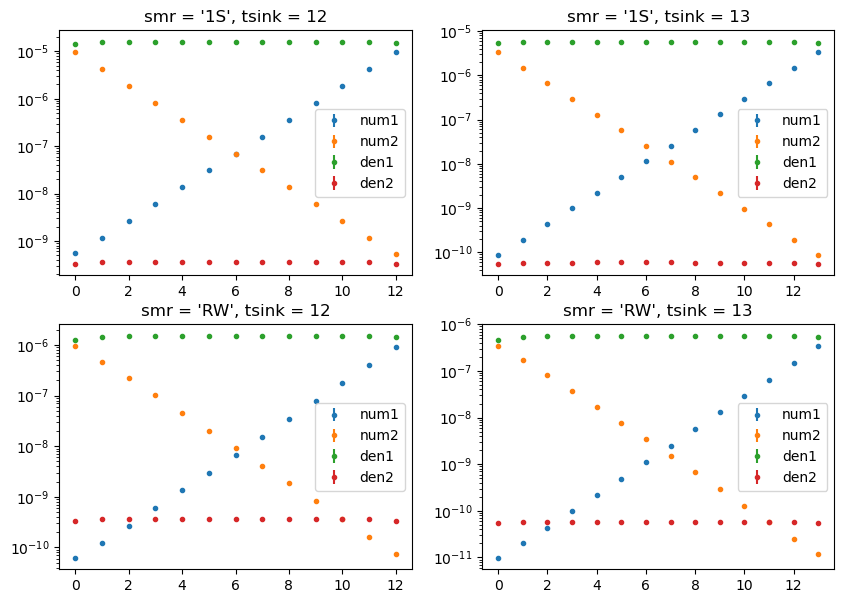

In [3]:
fig,ax = plt.subplots(2,2,figsize=(10,7))

data_read = {}
for i,smr in enumerate(['1S','RW']):
    data_read[smr] = {}
    for j,tsink in enumerate([Ta,Tb]):
        print(f'------------- {tsink = } --------- {smr = } -------------------')

        # Numerator 1
        corr = RatioFileString('P5_A1_V1_',tsink,heavy,smr,qq,light,mom)
        num1 = jkCorr(data[corr][:,:tsink+1], bsize=jk)
        print(corr)

        # Numerator 2
        corr = RatioFileString('V1_A1_P5_',tsink,light,smr,qq,heavy,mom)
        num2 = -jkCorr(data[corr][:,:tsink+1], bsize=jk)
        print(corr)
        # num2 = np.flip(num1,axis=0)


        # Denominator 1
        corr = RatioFileString('V1_V4_V1_',tsink,light,smr,qq,light,'000')
        den1 = jkCorr(data[corr][:,:tsink+1], bsize=jk)
        print(corr)

        # Denominator 2
        corr = RatioFileString('P5_V4_P5_',tsink,heavy,'1S',qq,heavy,'000')
        den2 = jkCorr(data[corr][:,:tsink+1], bsize=jk)
        print(corr)

        data_read[smr][tsink] = num1 * num2 / den1 / den2




        v = format(num1)
        ax[i,j].errorbar(np.arange(len(v)),gv.mean(v),gv.sdev(v),fmt='.',label='num1',color='C0')
        v = format(num2)
        ax[i,j].errorbar(np.arange(len(v)),gv.mean(v),gv.sdev(v),fmt='.',label='num2',color='C1')
        v = format(den1)
        ax[i,j].errorbar(np.arange(len(v)),gv.mean(v),gv.sdev(v),fmt='.',label='den1',color='C2')
        v = format(den2)
        ax[i,j].errorbar(np.arange(len(v)),gv.mean(v),gv.sdev(v),fmt='.',label='den2',color='C3')

        ax[i,j].set_title(f'{smr = }, {tsink = }')
        ax[i,j].set_yscale('log')
        ax[i,j].legend()

In [ ]:
format(data['P5_A1_V1_T12_k0.08574_RW_1S_rot_rot_m0.00507_k0.12201_p000'][:,:Ta+1])

-------------- tsink = 12 smr = '1S' --------------
[1.0795(96) 0.8742(53) 0.8693(64) 0.8619(69) 0.8557(73) 0.8524(78)
 0.8503(79) 0.8502(75) 0.8517(64) 0.8559(56) 0.8599(53) 0.8757(48)
 1.0563(78)]
-------------- tsink = 13 smr = '1S' --------------
[1.014(12) 0.8714(69) 0.8684(80) 0.8661(81) 0.8652(93) 0.8587(97)
 0.8567(99) 0.858(10) 0.8561(94) 0.8566(96) 0.8587(81) 0.8671(72)
 0.8742(62) 1.0311(96)]
-------------- tsink = 12 smr = 'RW' --------------
[0.1448(35) 0.1093(25) 0.1112(26) 0.1122(28) 0.1128(29) 0.1130(29)
 0.1147(28) 0.1166(29) 0.1178(30) 0.1188(32) 0.1197(34) 0.1214(35)
 0.1450(44)]
-------------- tsink = 13 smr = 'RW' --------------
[0.1334(36) 0.1056(28) 0.1086(29) 0.1107(30) 0.1109(30) 0.1115(30)
 0.1137(30) 0.1143(33) 0.1149(34) 0.1139(35) 0.1132(37) 0.1145(38)
 0.1147(38) 0.1322(45)]


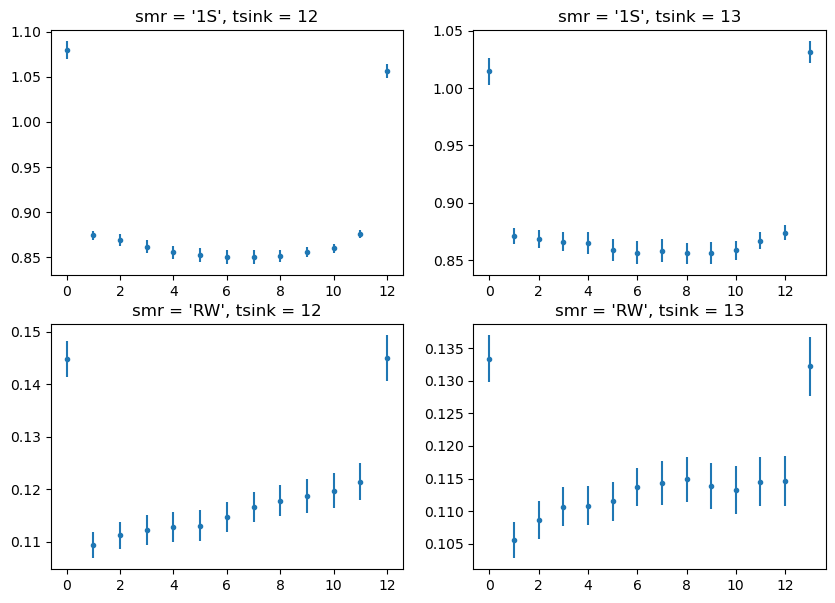

In [419]:
fig,ax = plt.subplots(2,2,figsize=(10,7))

for i,smr in enumerate(data_read):
    for j,tsink in enumerate(data_read[smr]):
        print(f'-------------- {tsink = } {smr = } --------------')
        print(format(data_read[smr][tsink]))

        v = format(data_read[smr][tsink])
        ax[i,j].errorbar(np.arange(len(v)),gv.mean(v),gv.sdev(v),fmt='.',label='num1',color='C0')
        ax[i,j].set_title(f'{smr = }, {tsink = }')
        

## Build correction factor

In the following cell we build the correction factor
$$\frac{Z_{D^*_a}(\mathbf p_\perp)}{\sqrt{Z_{D^*_a}(0)Z_{D_{1S}^*}(0)}} \frac{{M_{D^*}}^2}{{E^2_{D^*}}(\mathbf p)}$$

In [420]:
# This cell has only to be evaluated if next python cell is not

from b2heavy.ThreePointFunctions.types3pts import ratio_prerequisites

# frm = '/Users/pietro/code/data_analysis/data/QCDNf2p1stag/B2heavy/lattice24_old'
frm = '/Users/pietro/Desktop/lattice24/0.25/corr2_3'
req = ratio_prerequisites(ens,'ZRA1','000',readfrom=frm)
req

{'E0': 1.0809632444217314,
 'm0': 1.0809632444217314,
 'Z0': {'1S': 4.822281482026914, 'd': 0.04150728444106053},
 'Zpar': {'1S': None, 'd': None},
 'Zbot': {'1S': None, 'd': None},
 'Zp': {'1S': None, 'd': None},
 'wrecoil': 1.0,
 'jk': False}

Fill the following cells with appropriate values

In [421]:
req = {'E0': 1.0809632444217314,
 'm0': 1.0809632444217314,
 'Z0': {'1S': 4.822281482026914, 'd': 0.04150728444106053},
 'Zpar': {'1S': None, 'd': None},
 'Zbot': {'1S': None, 'd': None},
 'Zp': {'1S': None, 'd': None},
 'wrecoil': 1.0,
 'jk': False}

In [422]:
factor = {
    '1S': 1.,
    'RW': req['Z0']['d' ]/np.sqrt( req['Z0']['d' ] * req['Z0']['1S']),
}

factor

{'1S': 1.0, 'RW': 0.09277605082329385}

here we divide the data that we read by the correction factor

In [435]:
data_read['1S'][13][:,:]

array([[1.01387615, 0.87090025, 0.86814104, ..., 0.86673678, 0.87383754,
        1.03063254],
       [1.01524965, 0.87241765, 0.86936287, ..., 0.86812645, 0.87507981,
        1.03085055],
       [1.0146433 , 0.87104335, 0.86860486, ..., 0.86795908, 0.87467798,
        1.03188835],
       ...,
       [1.0160284 , 0.87201808, 0.86972491, ..., 0.86618727, 0.87355203,
        1.02961403],
       [1.01458179, 0.87185826, 0.86869317, ..., 0.86892495, 0.87551678,
        1.03224703],
       [1.01410197, 0.87135534, 0.86857634, ..., 0.86830652, 0.87503544,
        1.03124315]])

In [436]:
data_corr = {smr: {} for smr in data_read}

for smr in data_read:
    for tsink in data_read[smr]:
        data_corr[smr][tsink] = data_read[smr][tsink][:,:Ta] / factor[smr]
        print(f'-------------- {tsink = } {smr = } --------------')
        print(format(data_corr[smr][tsink]))

        print(data_corr[smr][tsink].shape)

-------------- tsink = 12 smr = '1S' --------------
[1.0795(96) 0.8742(53) 0.8693(64) 0.8619(69) 0.8557(73) 0.8524(78)
 0.8503(79) 0.8502(75) 0.8517(64) 0.8559(56) 0.8599(53) 0.8757(48)]
(90, 12)
-------------- tsink = 13 smr = '1S' --------------
[1.014(12) 0.8714(69) 0.8684(80) 0.8661(81) 0.8652(93) 0.8587(97)
 0.8567(99) 0.858(10) 0.8561(94) 0.8566(96) 0.8587(81) 0.8671(72)]
(90, 12)
-------------- tsink = 12 smr = 'RW' --------------
[1.561(38) 1.179(27) 1.198(28) 1.209(30) 1.216(31) 1.218(31) 1.236(30)
 1.257(31) 1.270(33) 1.280(35) 1.290(36) 1.309(38)]
(90, 12)
-------------- tsink = 13 smr = 'RW' --------------
[1.437(38) 1.138(30) 1.171(31) 1.193(32) 1.195(32) 1.202(32) 1.225(32)
 1.232(36) 1.238(37) 1.228(38) 1.220(40) 1.234(41)]
(90, 12)


## Exponentials + smoothening

$$
\bar R_{A_1}(t,T) = \frac{1}{2}R_{A_1}(t,T) e^{(E-M)T} + \frac{1}{4}R_{A_1}(t,T+1) e^{(E-M)(T+1)} + \frac{1}{4}R_{A_1}(t+1,T+1) e^{(E-M)(T+1)}
$$

In [437]:
barR = {}
barR['1S'] = data_corr['1S'][Ta  ]/2    +     data_corr['1S'][Tb]/4 +  np.roll(data_corr['1S'][Tb],-1,axis=1)/4 
barR['RW'] = data_corr['RW'][Ta  ]/2    +     data_corr['RW'][Tb]/4 +  np.roll(data_corr['RW'][Tb],-1,axis=1)/4 

In [438]:
for sm in ['1S','RW']:
    print(f'------------ {sm = } -------------')
    print(format(barR[sm]))

------------ sm = '1S' -------------
[1.0112(68) 0.8721(48) 0.8683(57) 0.8638(62) 0.8588(68) 0.8551(71)
 0.8539(71) 0.8537(68) 0.8540(63) 0.8567(58) 0.8614(50) 0.9082(43)]
------------ sm = 'RW' -------------
[1.424(27) 1.167(21) 1.190(22) 1.202(23) 1.207(24) 1.216(25) 1.232(25)
 1.246(26) 1.251(27) 1.252(29) 1.259(30) 1.322(29)]


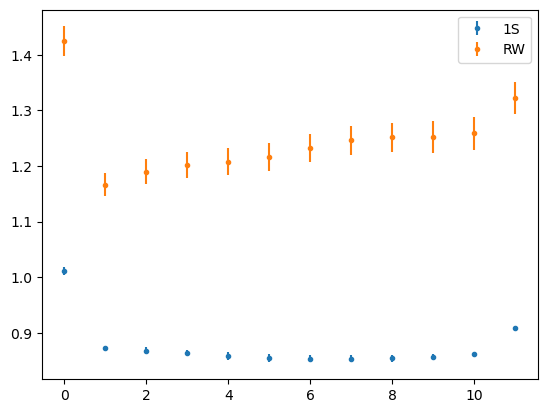

In [439]:
y1S = format(barR['1S'])
yRW = format(barR['RW'])
x   = np.arange(len(y1S))

plt.errorbar(x,gv.mean(y1S),gv.sdev(y1S),fmt='.',label='1S')
plt.errorbar(x,gv.mean(yRW),gv.sdev(yRW),fmt='.',label='RW')
plt.legend()

In [440]:
y1S

array([1.0112(68), 0.8721(48), 0.8683(57), 0.8638(62), 0.8588(68),
       0.8551(71), 0.8539(71), 0.8537(68), 0.8540(63), 0.8567(58),
       0.8614(50), 0.9082(43)], dtype=object)

In [441]:
yRW

array([1.424(27), 1.167(21), 1.190(22), 1.202(23), 1.207(24), 1.216(25),
       1.232(25), 1.246(26), 1.251(27), 1.252(29), 1.259(30), 1.322(29)],
      dtype=object)

# `CUSTOM`

In [410]:
from b2heavy.ThreePointFunctions.types3pts  import Ratio, RatioIO, ratio_prerequisites
from b2heavy.ThreePointFunctions.fitter3pts import RatioFitter, phys_energy_priors
from b2heavy.ThreePointFunctions.utils      import read_config_fit, dump_fit_object
from b2heavy.ThreePointFunctions.corr3pts   import BINSIZE

In [411]:
DATA_DIR = '/Users/pietro/code/data_analysis/BtoD/Alex/'
io = RatioIO(ens,'ZRA1',mom,PathToDataDir=DATA_DIR)
robj = RatioFitter(
    io,
    jkBin     = BINSIZE[ens],
    smearing  = ['1S','RW'],
    **req
)

In [412]:
robj.format()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 {'1S': array([-0.970(23), -0.837(19), -0.832(19), -0.829(19), -0.825(18),
         -0.826(19), -0.825(19), -0.829(19), -0.835(19), -0.841(19),
         -0.852(20), -0.865(20), -0.974(21)], dtype=object),
  'RW': array([-1.413(42), -1.168(33), -1.186(35), -1.202(36), -1.207(38),
         -1.211(40), -1.225(43), -1.241(46), -1.253(49), -1.261(50),
         -1.283(51), -1.306(51), -1.450(51)], dtype=object)})

In [343]:
format(barR['1S'])

array([1.0112(68), 0.8721(48), 0.8683(57), 0.8638(62), 0.8588(68),
       0.8551(71), 0.8539(71), 0.8537(68), 0.8540(63), 0.8567(58),
       0.8614(50), 0.8731(44), 1.0003(52)], dtype=object)

In [319]:
format(barR['RW'])

array([1.014(22), 0.727(14), 0.689(12), 0.670(12), 0.660(12), 0.656(12),
       0.655(13), 0.657(12), 0.660(12), 0.672(11), 0.687(12), 0.724(13),
       0.929(17)], dtype=object)